# Indian Liver Patient Dataset

### The following notebook contains the following

### • Exploratory analysis of the dataset 
### • Data cleansing (one-hot encoding, filling missing values)
### • Predictive model training for benchmark score
### • Testing data-preprocessing methods on benchmark score (feature selection, min-max scaling)
### • Implementing only the methods which increase the score
### • SMOTE oversampling
### • Hyperparameter tuning
### • Final model evaluation and rebalancing tests

#### approx run time: 350 seconds

In [1]:
#import requried libraries and modules

# !pip install optuna -- not used as of submission
# !pip install plotly
# !pip install scikit-plot
# !pip install shap
# !pip install mlxtend

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv 
from sklearn.datasets import make_classification
from sklearn.model_selection import HalvingGridSearchCV
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.datasets import load_digits
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import mlxtend
from mlxtend.plotting import plot_decision_regions
import warnings
import shap
import optuna
import scikitplot as skplt
warnings.filterwarnings("ignore")
np.random.seed(0)
%matplotlib inline


In [2]:
#read in the data and set column headers

colnames=['Age', 'Sex', 'TB Total Bilirubin', 'DB Direct Bilirubin', 'Alkphos Alkaline Phosphotase',
          'Sgpt Alamine Aminotransferase','Sgot Aspartate Aminotransferase',
         'TP Total Proteins', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio','Target'] 

df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00225/Indian%20Liver%20Patient%20Dataset%20(ILPD).csv",
                 names = colnames, header=None)

### Exploratory analysis of the dataset and feature space

In [3]:
#inspect the dataframe

df.head()

Age     Sex  TB Total Bilirubin  DB Direct Bilirubin  \
0   65  Female                 0.7                  0.1   
1   62    Male                10.9                  5.5   
2   62    Male                 7.3                  4.1   
3   58    Male                 1.0                  0.4   
4   72    Male                 3.9                  2.0   

   Alkphos Alkaline Phosphotase  Sgpt Alamine Aminotransferase  \
0                           187                             16   
1                           699                             64   
2                           490                             60   
3                           182                             14   
4                           195                             27   

   Sgot Aspartate Aminotransferase  TP Total Proteins  ALB Albumin  \
0                               18                6.8          3.3   
1                              100                7.5          3.2   
2                               68                7.0          3.3   
3                               20                6.8          3.4   
4                               59                7.3          2.4   

   A/G Ratio Albumin and Globulin Ratio  Target  
0                                  0.90       1  
1                                  0.74       1  
2                                  0.89       1  
3                                  1.00       1  
4                                  0.40       1

In [4]:
#data types and feature value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   583 non-null    int64  
 1   Sex                                   583 non-null    object 
 2   TB Total Bilirubin                    583 non-null    float64
 3   DB Direct Bilirubin                   583 non-null    float64
 4   Alkphos Alkaline Phosphotase          583 non-null    int64  
 5   Sgpt Alamine Aminotransferase         583 non-null    int64  
 6   Sgot Aspartate Aminotransferase       583 non-null    int64  
 7   TP Total Proteins                     583 non-null    float64
 8   ALB Albumin                           583 non-null    float64
 9   A/G Ratio Albumin and Globulin Ratio  579 non-null    float64
 10  Target                                583 non-null    int64  
dtypes: float64(5), int6

In [5]:
#basic distribution info
df.describe()

Age  TB Total Bilirubin  DB Direct Bilirubin  \
count  583.000000          583.000000           583.000000   
mean    44.746141            3.298799             1.486106   
std     16.189833            6.209522             2.808498   
min      4.000000            0.400000             0.100000   
25%     33.000000            0.800000             0.200000   
50%     45.000000            1.000000             0.300000   
75%     58.000000            2.600000             1.300000   
max     90.000000           75.000000            19.700000   

       Alkphos Alkaline Phosphotase  Sgpt Alamine Aminotransferase  \
count                    583.000000                     583.000000   
mean                     290.576329                      80.713551   
std                      242.937989                     182.620356   
min                       63.000000                      10.000000   
25%                      175.500000                      23.000000   
50%                      208.000000                      35.000000   
75%                      298.000000                      60.500000   
max                     2110.000000                    2000.000000   

       Sgot Aspartate Aminotransferase  TP Total Proteins  ALB Albumin  \
count                       583.000000         583.000000   583.000000   
mean                        109.910806           6.483190     3.141852   
std                         288.918529           1.085451     0.795519   
min                          10.000000           2.700000     0.900000   
25%                          25.000000           5.800000     2.600000   
50%                          42.000000           6.600000     3.100000   
75%                          87.000000           7.200000     3.800000   
max                        4929.000000           9.600000     5.500000   

       A/G Ratio Albumin and Globulin Ratio      Target  
count                            579.000000  583.000000  
mean                               0.947064    1.286449  
std                                0.319592    0.452490  
min                                0.300000    1.000000  
25%                                0.700000    1.000000  
50%                                0.930000    1.000000  
75%                                1.100000    2.000000  
max                                2.800000    2.000000

<AxesSubplot:xlabel='Target', ylabel='count'>

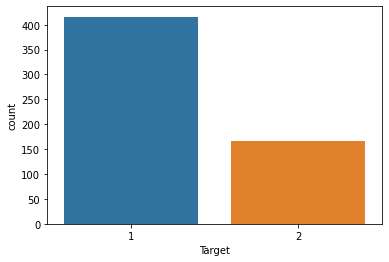

In [6]:
#target feature imbalance
sns.countplot(data=df, x = 'Target')

In [7]:
#count target feature imbalance 
Counter(df['Target'])

Counter({1: 416, 2: 167})

<AxesSubplot:xlabel='Sex', ylabel='count'>

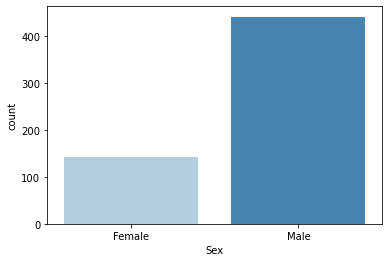

In [8]:
sns.countplot(data=df, x = 'Sex',palette = 'Blues')

<AxesSubplot:>

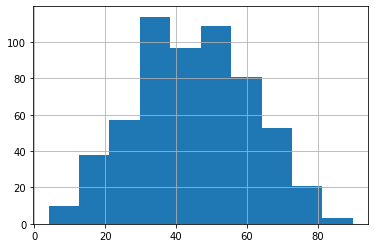

In [9]:
df.Age.hist()

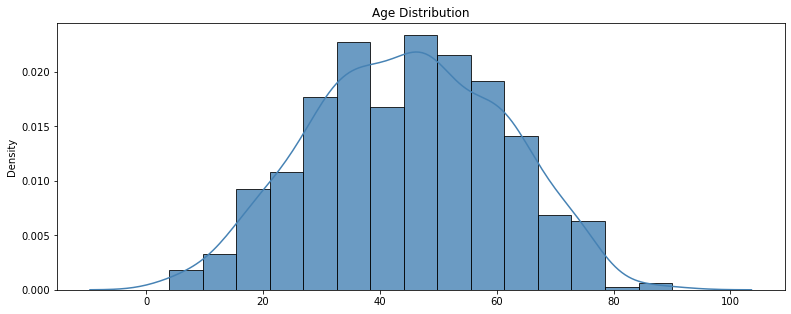

In [10]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(16, 12))
grid = gridspec.GridSpec(ncols=6, nrows=3, figure=fig)
ax5 = fig.add_subplot(grid[2, :4])

ax5.set_title('Age Distribution')

sns.distplot(df[['Age']],
                 hist_kws={
                 'rwidth': 1,
                 'edgecolor': 'black',
                 'alpha': 0.8},
                 color = '#4682B4')

plt.show()

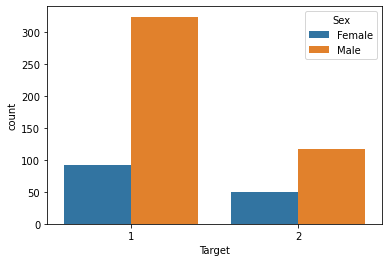

In [11]:
ax = sns.countplot(x="Target", hue="Sex", data=df)

In [12]:
df['Sex'].replace('Female',0,inplace=True)
df['Sex'].replace('Male',1,inplace=True)

<AxesSubplot:xlabel='TB Total Bilirubin', ylabel='DB Direct Bilirubin'>

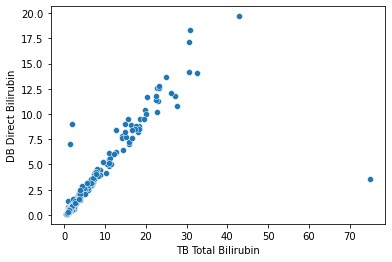

In [13]:
sns.scatterplot(data=df, x="TB Total Bilirubin", y="DB Direct Bilirubin")

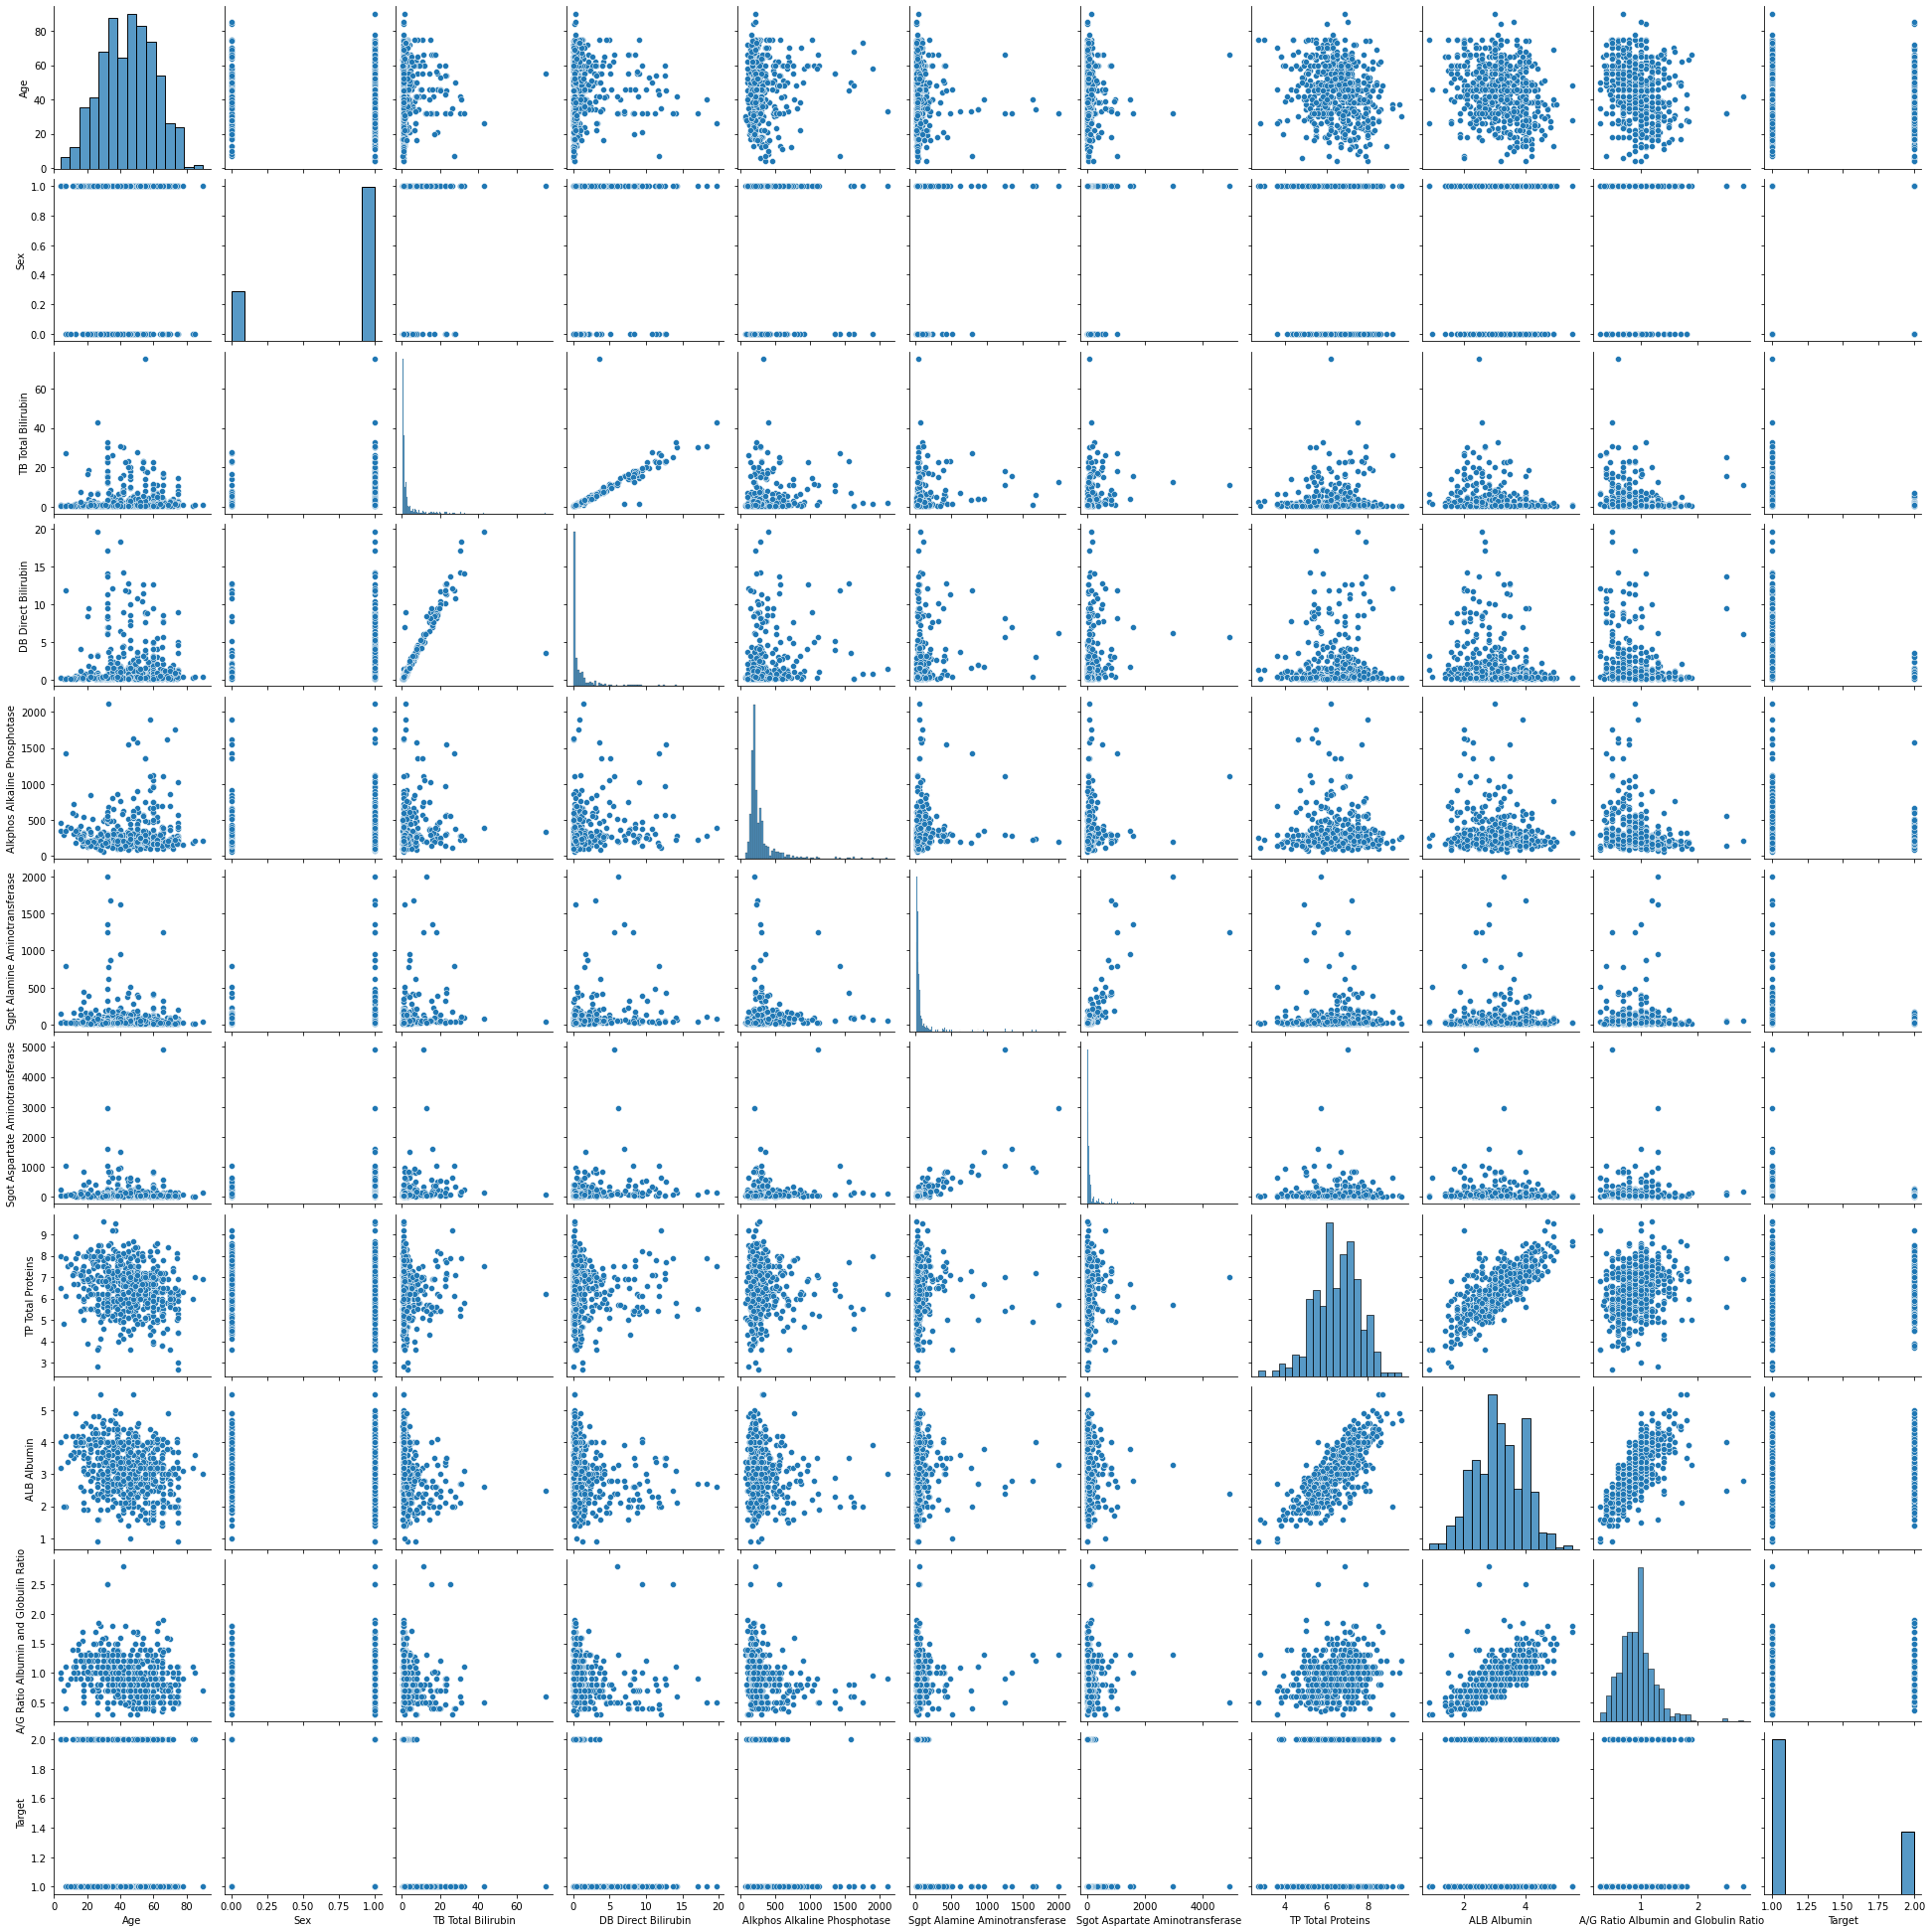

In [14]:
# visualize all relationships between features before calculating correlations
sns.pairplot(df)

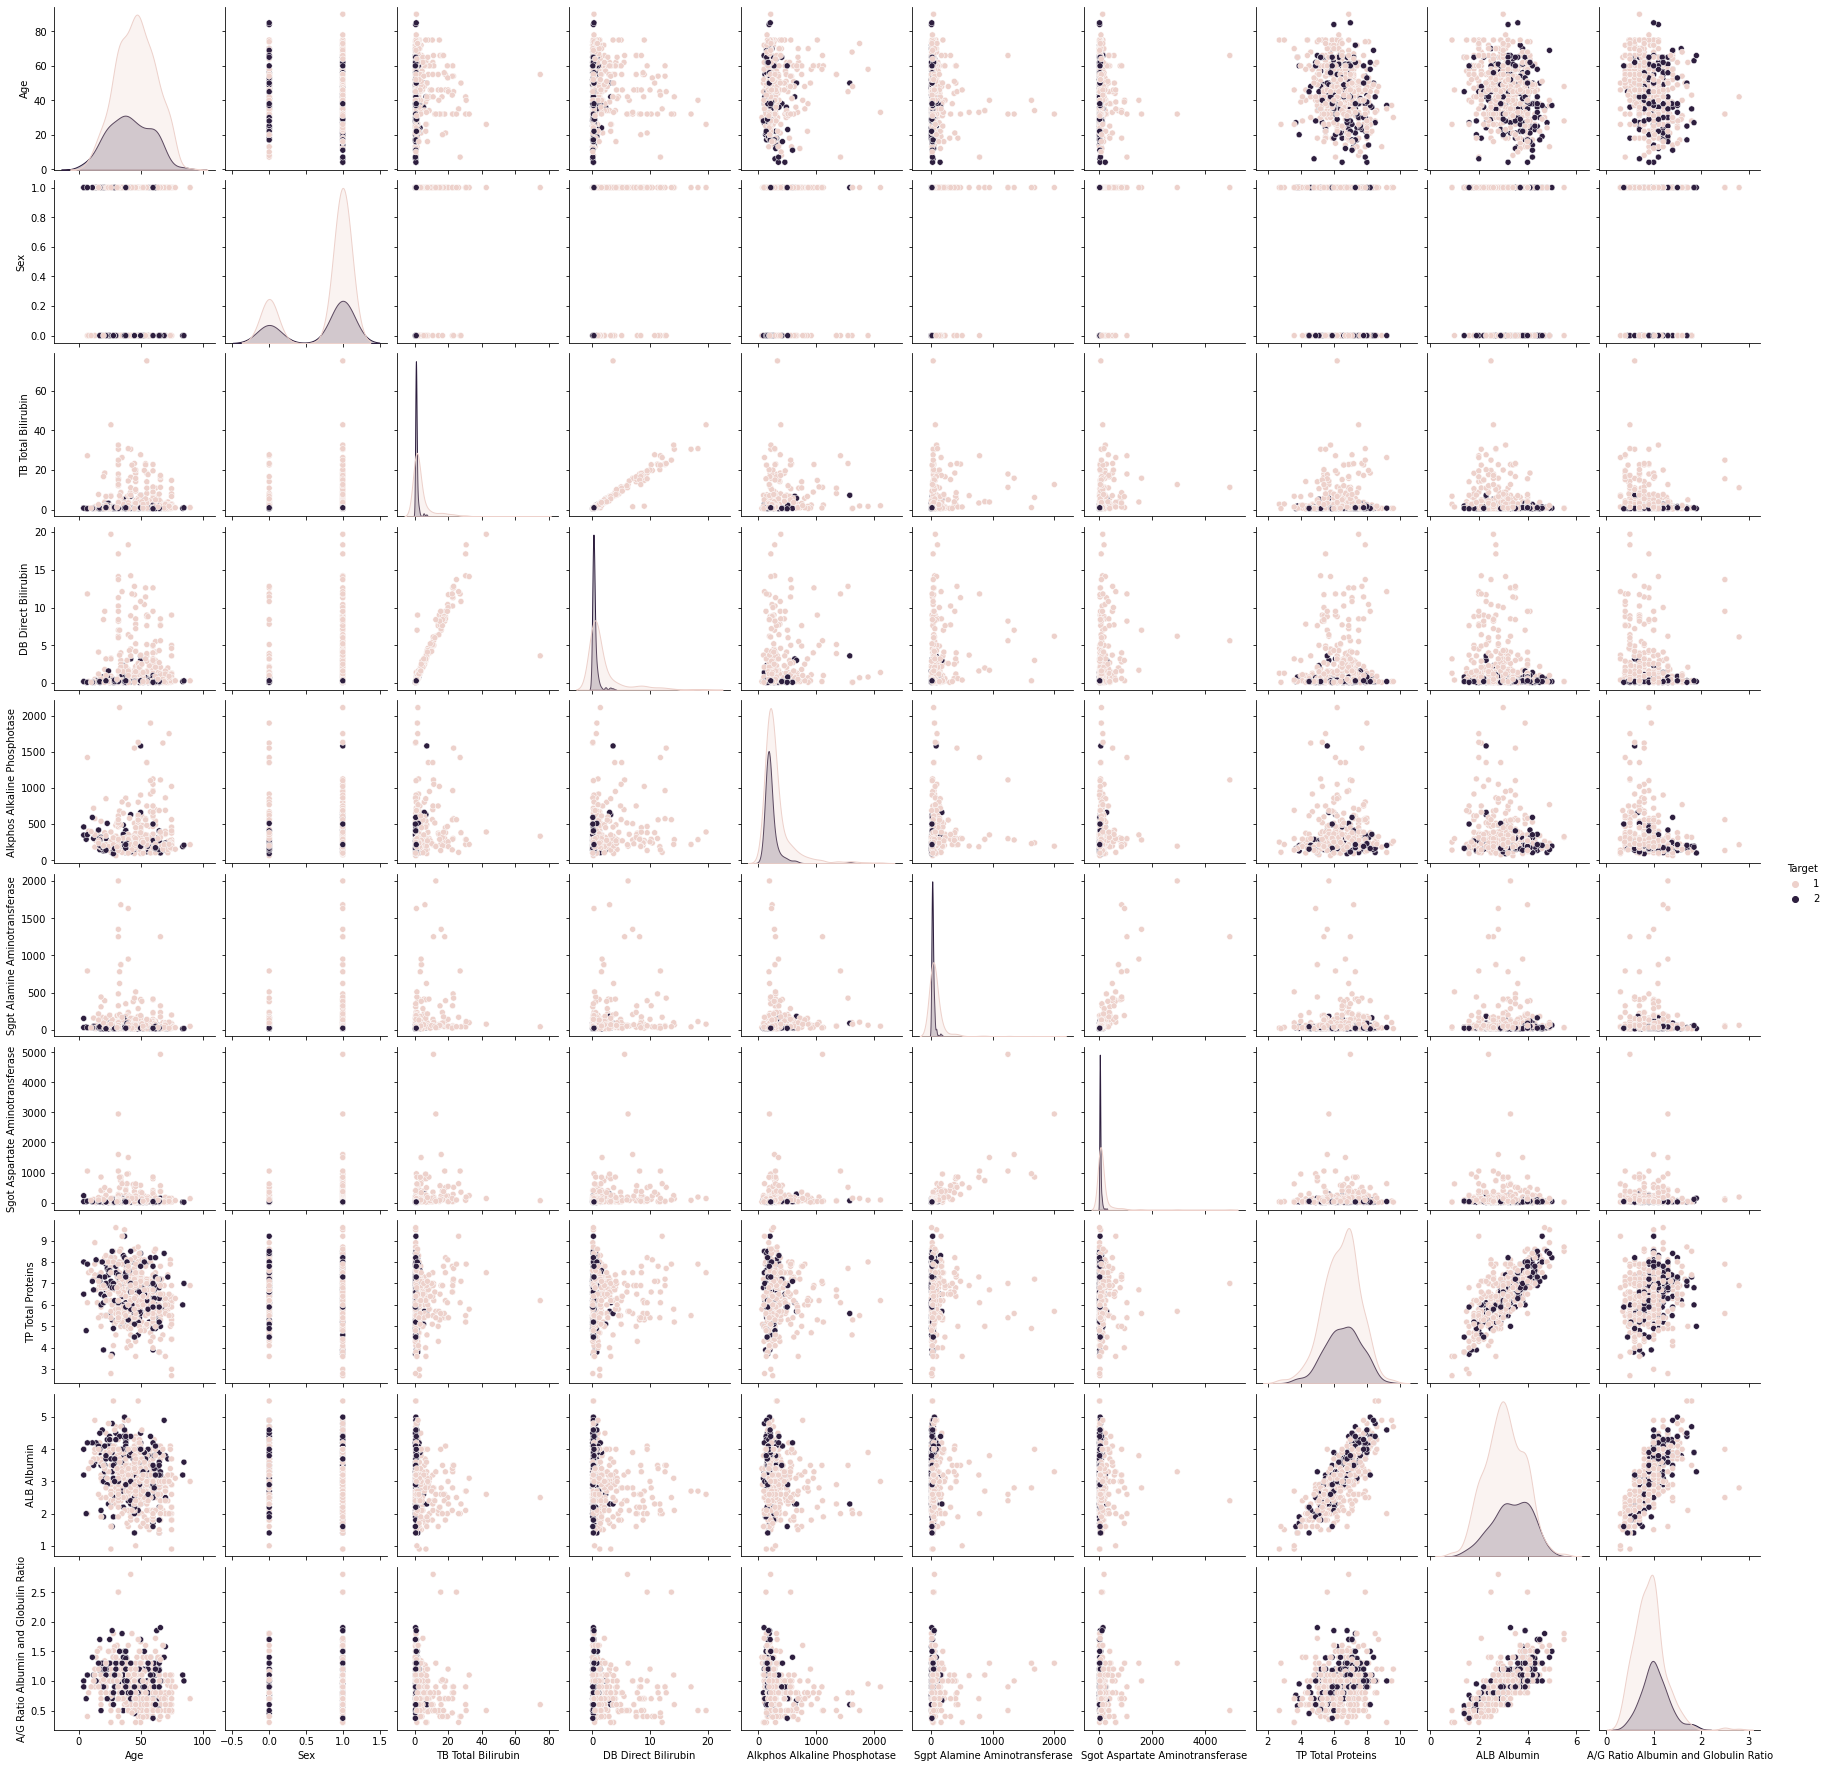

In [15]:
sns.pairplot(df,hue='Target')

Text(0.5, 1.0, 'Outliers')

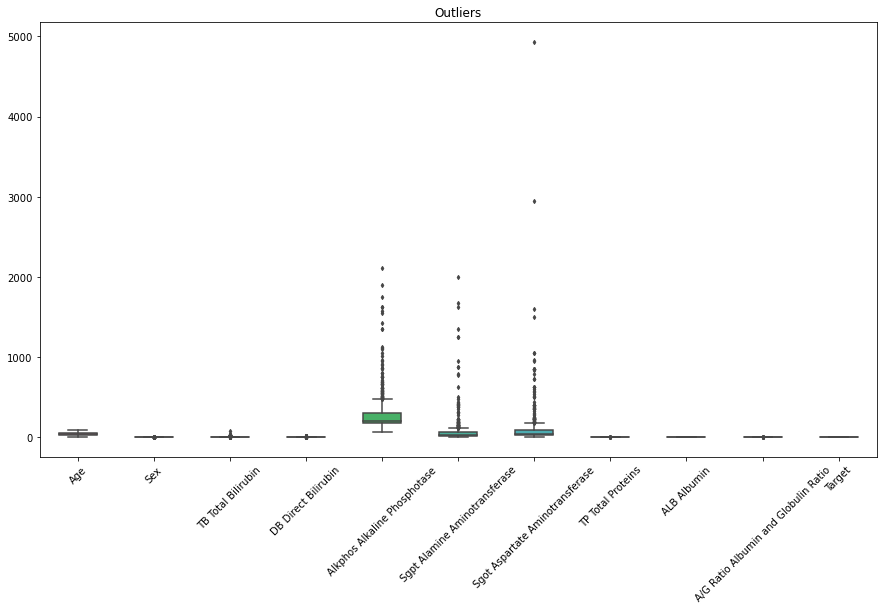

In [16]:
#plot outliers
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df, width = 0.5, ax=ax, fliersize=3)
plt.xticks(rotation=45)
plt.title("Outliers")

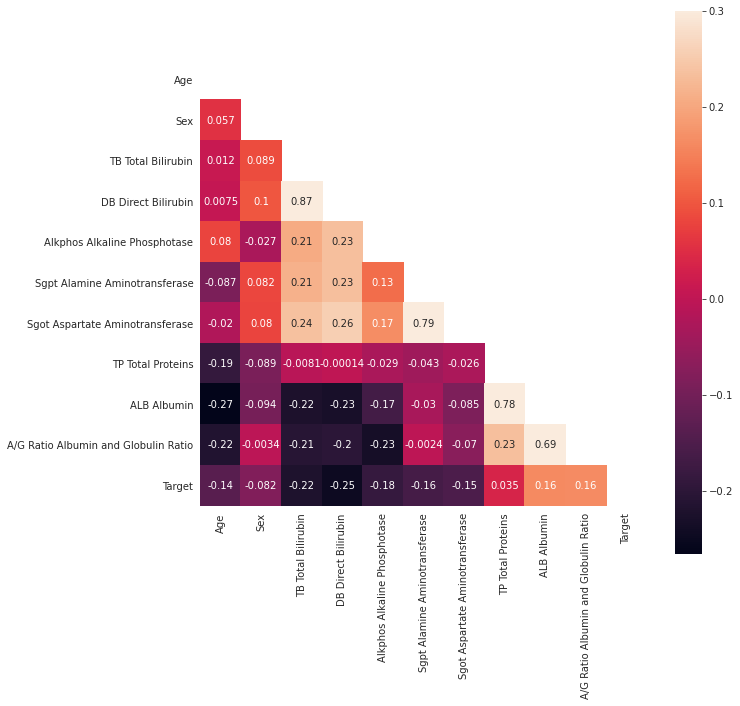

In [17]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,annot=True)


<AxesSubplot:title={'center':'Correlation with target'}>

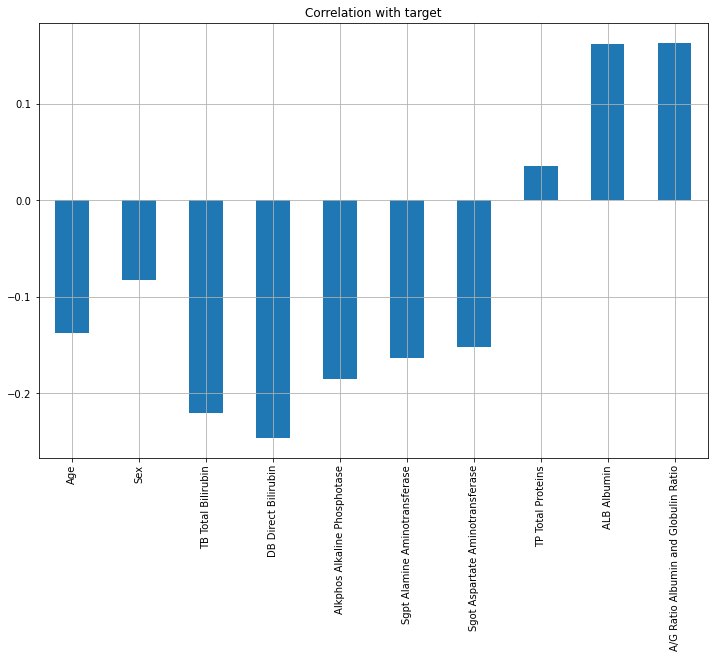

In [18]:
df.drop('Target', axis=1).corrwith(df.Target).plot(kind='bar', grid=True, figsize=(12, 8), 
                                                   title="Correlation with target")

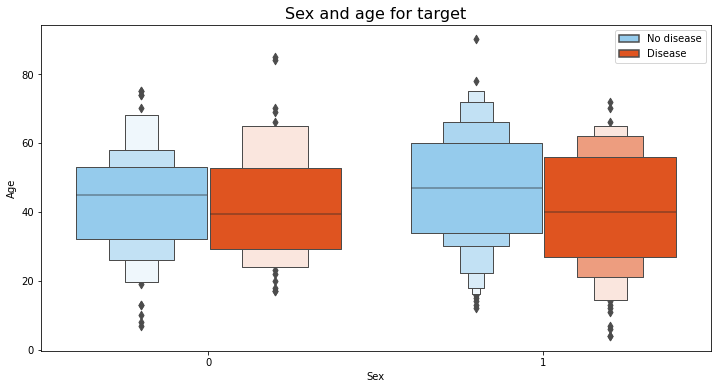

In [19]:
plt.figure(figsize=(12,6))
palette=['lightskyblue','orangered']
s1=sns.boxenplot(x=df.Sex, y=df.Age, hue=df.Target, palette=palette, linewidth=3)
handles = s1.get_legend_handles_labels()[0]
s1.legend(handles, ['No disease', 'Disease'])
s1.set_title("Sex and age for target",fontsize=16)
plt.show()

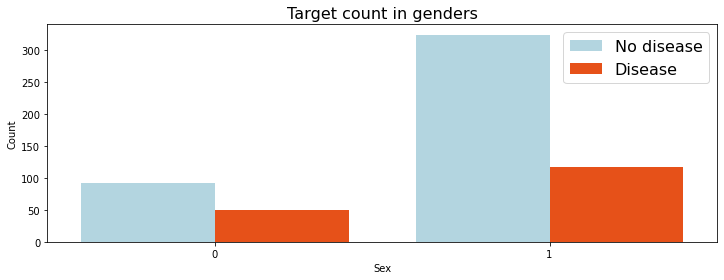

In [20]:
plt.figure(figsize=(12,4))
labels = ['Female','Male']
sns.countplot(df['Sex'], hue=df['Target'], palette=['lightblue','orangered'], saturation=0.8)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Target count in genders', fontsize=16)
plt.legend(loc='upper right', fontsize=16, labels=['No disease', 'Disease'])
plt.show()

#### There are some linearly correlated features, such as Total and Direct Bilirubin. These will likely be removed by RFE after finding benchmark scores for comparison. There may be little benefit removing them at this stage.

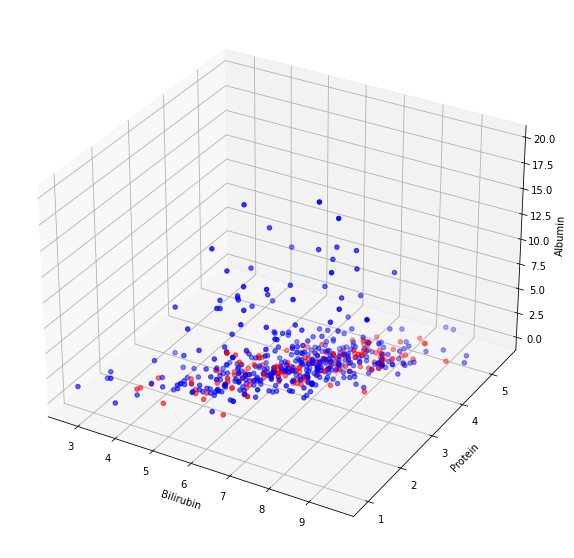

In [21]:
from mpl_toolkits.mplot3d import Axes3D

feature1 = df['TP Total Proteins'].values
feature2 = df['ALB Albumin'].values 
feature3 = df['DB Direct Bilirubin'].values

df['Target']=df['Target'].astype('str')

c = df['Target'].values
df['Target']=df['Target'].astype('int')
c[c=='1'] = 'b' #negative diagnosis diabetes
c[c=='2'] = 'r' #positive diagnosis diabetes

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, feature3, c=c)
ax.set_xlabel('Bilirubin')
ax.set_ylabel('Protein')
ax.set_zlabel('Albumin')

plt.show()

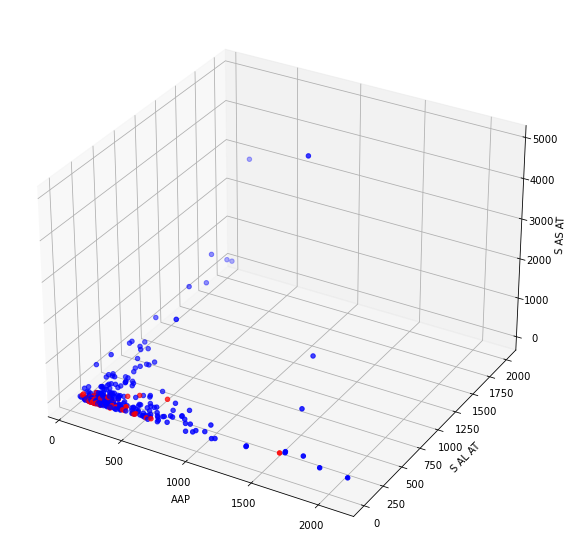

In [22]:
feature4 = df['Alkphos Alkaline Phosphotase'].values
feature5 = df['Sgpt Alamine Aminotransferase'].values 
feature6 = df['Sgot Aspartate Aminotransferase'].values

df['Target']=df['Target'].astype('str')

c = df['Target'].values
df['Target']=df['Target'].astype('int')
c[c=='1'] = 'b' #negative diagnosis diabetes
c[c=='2'] = 'r' #positive diagnosis diabetes

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature4, feature5, feature6, c=c)
ax.set_xlabel('AAP')
ax.set_ylabel('S AL AT')
ax.set_zlabel('S AS AT')

plt.show()

In [23]:
import plotly.express as px

# 3D scatterplot:

fig = px.scatter_3d(df, x='TB Total Bilirubin', y='Alkphos Alkaline Phosphotase', z='Age', size='ALB Albumin',
              color='Sex', opacity=0.8)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Outliers exist in this space.

In [24]:
#check for null values
df.isna().sum()

Age                                     0
Sex                                     0
TB Total Bilirubin                      0
DB Direct Bilirubin                     0
Alkphos Alkaline Phosphotase            0
Sgpt Alamine Aminotransferase           0
Sgot Aspartate Aminotransferase         0
TP Total Proteins                       0
ALB Albumin                             0
A/G Ratio Albumin and Globulin Ratio    4
Target                                  0
dtype: int64

In [25]:
df['A/G Ratio Albumin and Globulin Ratio'].mean()

0.9470639032815201

In [26]:
df['A/G Ratio Albumin and Globulin Ratio'].median()

0.93

In [27]:
#replace missing values with feature median
df['A/G Ratio Albumin and Globulin Ratio'].fillna(df['A/G Ratio Albumin and Globulin Ratio'].median(),inplace=True)

In [28]:
df['A/G Ratio Albumin and Globulin Ratio'].isna().sum()

0

In [29]:
#one-hot encoding sex
df = pd.get_dummies(df, columns=['Sex'])

In [30]:
df

Age  TB Total Bilirubin  DB Direct Bilirubin  \
0     65                 0.7                  0.1   
1     62                10.9                  5.5   
2     62                 7.3                  4.1   
3     58                 1.0                  0.4   
4     72                 3.9                  2.0   
..   ...                 ...                  ...   
578   60                 0.5                  0.1   
579   40                 0.6                  0.1   
580   52                 0.8                  0.2   
581   31                 1.3                  0.5   
582   38                 1.0                  0.3   

     Alkphos Alkaline Phosphotase  Sgpt Alamine Aminotransferase  \
0                             187                             16   
1                             699                             64   
2                             490                             60   
3                             182                             14   
4                             195                             27   
..                            ...                            ...   
578                           500                             20   
579                            98                             35   
580                           245                             48   
581                           184                             29   
582                           216                             21   

     Sgot Aspartate Aminotransferase  TP Total Proteins  ALB Albumin  \
0                                 18                6.8          3.3   
1                                100                7.5          3.2   
2                                 68                7.0          3.3   
3                                 20                6.8          3.4   
4                                 59                7.3          2.4   
..                               ...                ...          ...   
578                               34                5.9          1.6   
579                               31                6.0          3.2   
580                               49                6.4          3.2   
581                               32                6.8          3.4   
582                               24                7.3          4.4   

     A/G Ratio Albumin and Globulin Ratio  Target  Sex_0  Sex_1  
0                                    0.90       1      1      0  
1                                    0.74       1      0      1  
2                                    0.89       1      0      1  
3                                    1.00       1      0      1  
4                                    0.40       1      0      1  
..                                    ...     ...    ...    ...  
578                                  0.37       2      0      1  
579                                  1.10       1      0      1  
580                                  1.00       1      0      1  
581                                  1.00       1      0      1  
582                                  1.50       2      0      1  

[583 rows x 12 columns]

In [31]:
#generate baseline variables to assess accuracy without feature selection
X = df.drop('Target',axis=1)
y = df['Target']

### Prevent leakage by obtaining a hold-out

In [32]:
X, X_holdout, y, y_holdout = train_test_split(X, y, test_size=0.2,
                                              random_state=111,shuffle=True)

### Feature importance

In [33]:
#identify low-value features ---- optional: this can take up to 5 extra minutes ----
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, n_features_to_select=5, step=1)
# selector = selector.fit(X, y)
# print(selector.ranking_)

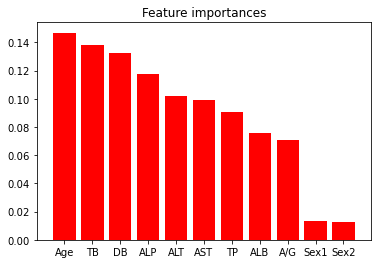

In [34]:
#visualise feature importance
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]),['Age','TB','DB','ALP','ALT','AST','TP','ALB','A/G','Sex1','Sex2'])
plt.xlim([-1, X.shape[1]])
plt.show()

In [35]:
importances

array([0.11783563, 0.09900848, 0.07068801, 0.14690192, 0.13819781,
       0.13234787, 0.09093612, 0.10200959, 0.07603873, 0.01267538,
       0.01336047])

### Obtaining benchmark scores before further processing via cross-validation on training set

KNN: 0.652322 (0.016803)
RF: 0.699520 (0.036359)
LR: 0.708167 (0.024705)
SVM: 0.716632 (0.039450)


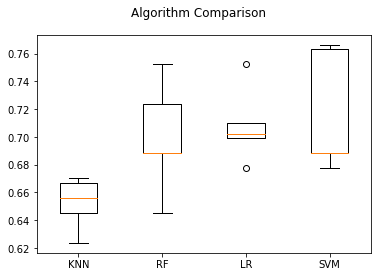

In [36]:
from sklearn import svm

# models
models = []
models.append(('KNN',KNeighborsClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('LR',LogisticRegression(max_iter=2500)))
models.append(('SVM',svm.SVC()))

results = []
names = []
scoring = 'accuracy'

# cross validation
for name, model in models:
    kfold = model_selection.KFold(n_splits=5,random_state = 111,shuffle=True)
    cv_results = model_selection.cross_val_score(model, X,y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [37]:
y_holdout.value_counts()

1    82
2    35
Name: Target, dtype: int64

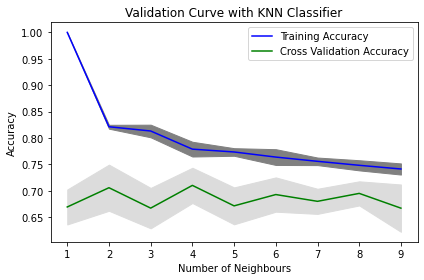

In [38]:
# parameter range
parameter_range = np.arange(1, 10, 1)

# 10-fold cross validation
train_score, test_score = validation_curve(KNeighborsClassifier(), X, y,
                                           param_name = "n_neighbors",
                                           param_range = parameter_range,
                                           cv = 5, scoring = "accuracy")

# mean and standard deviation (training)
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

# mean and standard deviation (test)
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

# mean accuracy (train and test)
plt.plot(parameter_range, mean_train_score,
         label = "Training Accuracy", color = 'b')
plt.plot(parameter_range, mean_test_score,
label = "Cross Validation Accuracy", color = 'g')
plt.fill_between(parameter_range, mean_train_score - std_train_score, mean_train_score + std_train_score, color="gray")
plt.fill_between(parameter_range, mean_test_score - std_test_score, mean_test_score + std_test_score, color="gainsboro")
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()


 

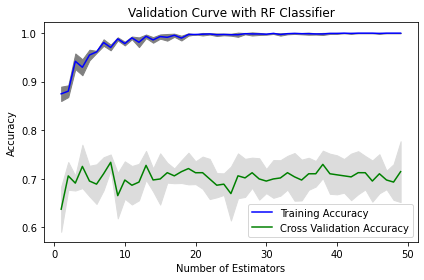

In [39]:
parameter_range = np.arange(1,50,1)
train_score, test_score = validation_curve(RandomForestClassifier(), X, y,
                                           param_name = "n_estimators",
                                           param_range = parameter_range,
                                           cv = 5, scoring = "accuracy")

# mean and standard deviation (train)
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)

# mean and standard deviation (test)
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)

# Plot mean accuracy (train and test)
plt.plot(parameter_range, mean_train_score,
         label = "Training Accuracy", color = 'b')
plt.plot(parameter_range, mean_test_score,
label = "Cross Validation Accuracy", color = 'g')
plt.fill_between(parameter_range, mean_train_score - std_train_score, mean_train_score + std_train_score, color="gray")
plt.fill_between(parameter_range, mean_test_score - std_test_score, mean_test_score + std_test_score, color="gainsboro")
# Creating the plot
plt.title("Validation Curve with RF Classifier")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [40]:
# Removing redundant features
X = X.iloc[:,[0,1,3,4,5,6]]

In [41]:
results_post_feature_selection = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state = 111,shuffle=True)
    cv_results_post_feature_selection = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results_post_feature_selection.append(cv_results_post_feature_selection)
    msg = "%s: %f (%f)" % (name, cv_results_post_feature_selection.mean(), cv_results_post_feature_selection.std())
    print(msg)

KNN: 0.652345 (0.011344)
RF: 0.695287 (0.021987)
LR: 0.712469 (0.020490)
SVM: 0.716632 (0.039450)


In [42]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state = 111,shuffle=True)
    cv_results_post_feature_selection = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results_post_feature_selection.append(cv_results_post_feature_selection)
    print(f'{name} A total improvement of: {cv_results_post_feature_selection.mean() - cv_results.mean()}')

KNN A total improvement of: -0.064287348432853
RF A total improvement of: -0.023587279798673144
LR A total improvement of: -0.0041638069091739505
SVM A total improvement of: 0.0


### Scaling the data and moving on with only models of interest

In [43]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_holdout = X_holdout.iloc[:,[0,1,3,4,5,6]]
# X_holdout = scaler.transform(X_holdout)
X_holdout[:] = scaler.transform(X_holdout)

In [44]:
Models = []
Models.append(('KNN',KNeighborsClassifier()))
Models.append(('RF',RandomForestClassifier()))

results_post_feature_selection = []
for name, model in Models:
    kfold = model_selection.KFold(n_splits=5, random_state = 111,shuffle=True)
    cv_results_post_feature_selection = model_selection.cross_val_score(model, X_scaled, y, cv=kfold, scoring=scoring)
    results_post_feature_selection.append(cv_results_post_feature_selection)
    msg = "%s: %f (%f)" % (name, cv_results_post_feature_selection.mean(), cv_results_post_feature_selection.std())
    print(msg)

KNN: 0.671654 (0.019032)
RF: 0.680188 (0.025660)


In [45]:
X_standard = StandardScaler().fit_transform(X)

In [46]:
results_post_feature_selection = []
for name, model in Models:
    kfold = model_selection.KFold(n_splits=5, random_state = 111,shuffle=True)
    cv_results_post_feature_selection = model_selection.cross_val_score(model, X_standard, y, cv=kfold, scoring=scoring)
    results_post_feature_selection.append(cv_results_post_feature_selection)
    msg = "%s: %f (%f)" % (name, cv_results_post_feature_selection.mean(), cv_results_post_feature_selection.std())
    print(msg)

KNN: 0.667422 (0.032148)
RF: 0.680210 (0.031143)


### Oversampling
#### Reduces bias if model is to be used on unseen data by increasing recall

In [47]:
sm = SMOTE(random_state=42)
Counter(y)

Counter({1: 334, 2: 132})

In [48]:
X_res, y_res = sm.fit_resample(X_scaled, y)
Counter(y_res)

Counter({1: 334, 2: 334})

In [49]:
results_smote = []
for name, model in Models:
    kfold = model_selection.KFold(n_splits=10, random_state = 111,shuffle=True)
    cv_results_post_feature_selection = model_selection.cross_val_score(model, X_res, y_res, cv=kfold, scoring=scoring)
    results_post_feature_selection.append(cv_results_post_feature_selection)
    msg = "%s: %f (%f)" % (name, cv_results_post_feature_selection.mean(), cv_results_post_feature_selection.std())
    print(msg)

KNN: 0.717232 (0.049838)
RF: 0.811443 (0.040447)


#### Pre-balanced fit causes the model to 'cheat' and predict a certain class for every attempt

In [50]:
from sklearn import metrics
model = RandomForestClassifier()
model.fit(X,y)
y_pred = model.predict(X_holdout)
print(classification_report(y_holdout,y_pred))
model = KNeighborsClassifier()
model.fit(X,y)
y_pred = model.predict(X_holdout)
print(classification_report(y_holdout,y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        82
           2       0.30      1.00      0.46        35

    accuracy                           0.30       117
   macro avg       0.15      0.50      0.23       117
weighted avg       0.09      0.30      0.14       117

              precision    recall  f1-score   support

           1       0.70      1.00      0.82        82
           2       0.00      0.00      0.00        35

    accuracy                           0.70       117
   macro avg       0.35      0.50      0.41       117
weighted avg       0.49      0.70      0.58       117



In [51]:
# baseline performance pre-tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
for name, model in Models:
    model.fit(X,y)
scoring = ['precision_macro', 'recall_macro','accuracy']
for model in Models:
    print(model)
for name, model in Models:
    scores = cross_val_score(model, X_holdout, y_holdout, cv=5)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

('KNN', KNeighborsClassifier())
('RF', RandomForestClassifier())
0.63 accuracy with a standard deviation of 0.03
0.69 accuracy with a standard deviation of 0.07


### Final baseline classification accuracy scores:
#### Random Forest - 0.68
#### KNN - 0.63

In [52]:
model = RandomForestClassifier()
model.fit(X_res,y_res)
y_pred = model.predict(X_holdout)
print(classification_report(y_holdout,y_pred))
model = KNeighborsClassifier()
model.fit(X_res,y_res)
y_pred = model.predict(X_holdout)
print(classification_report(y_holdout,y_pred))

              precision    recall  f1-score   support

           1       0.83      0.82      0.82        82
           2       0.58      0.60      0.59        35

    accuracy                           0.75       117
   macro avg       0.71      0.71      0.71       117
weighted avg       0.75      0.75      0.75       117

              precision    recall  f1-score   support

           1       0.84      0.63      0.72        82
           2       0.45      0.71      0.56        35

    accuracy                           0.66       117
   macro avg       0.65      0.67      0.64       117
weighted avg       0.72      0.66      0.67       117



### Hyperparameter tuning

#### Random Forest

In [82]:
#optuna first (not used because its bayesian and i just want nice plots)

def objective(trial):
      
      n_estimators = trial.suggest_int('n_estimators', 100, 120)
      max_depth = int(trial.suggest_loguniform('max_depth', 1, 10))
#       criterion = trial.suggest_categorical('criterion', 'entropy', 'gini')
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1,5)
      clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,min_samples_leaf=min_samples_leaf)
      return cross_val_score(clf, X_res, y_res, 
           n_jobs=-1, cv=3).mean()

In [83]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=600)
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


[I 2022-05-13 23:25:31,188] A new study created in memory with name: no-name-265f13df-c4f8-426c-a035-152d2c2fcace
[I 2022-05-13 23:25:31,762] Trial 0 finished with value: 0.7380452201080003 and parameters: {'n_estimators': 119, 'max_depth': 1.9583861774813995, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7380452201080003.
[I 2022-05-13 23:25:32,307] Trial 1 finished with value: 0.7335407156034958 and parameters: {'n_estimators': 107, 'max_depth': 4.331081493709087, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7380452201080003.
[I 2022-05-13 23:25:32,625] Trial 2 finished with value: 0.7365437186064989 and parameters: {'n_estimators': 102, 'max_depth': 2.1282862142279844, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7380452201080003.
[I 2022-05-13 23:25:32,931] Trial 3 finished with value: 0.7290631438613501 and parameters: {'n_estimators': 116, 'max_depth': 1.901232034446432, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7380452201080003.
[I 2022-05-1

[I 2022-05-13 23:25:49,025] Trial 35 finished with value: 0.771004188044547 and parameters: {'n_estimators': 115, 'max_depth': 8.918073596805714, 'min_samples_leaf': 2}. Best is trial 34 with value: 0.7755019593584617.
[I 2022-05-13 23:25:49,471] Trial 36 finished with value: 0.7605071439152157 and parameters: {'n_estimators': 115, 'max_depth': 8.605860975252254, 'min_samples_leaf': 2}. Best is trial 34 with value: 0.7755019593584617.
[I 2022-05-13 23:25:49,962] Trial 37 finished with value: 0.7350624166767664 and parameters: {'n_estimators': 115, 'max_depth': 2.0028490729289947, 'min_samples_leaf': 2}. Best is trial 34 with value: 0.7755019593584617.
[I 2022-05-13 23:25:50,294] Trial 38 finished with value: 0.7230840706177029 and parameters: {'n_estimators': 114, 'max_depth': 2.525791099220528, 'min_samples_leaf': 2}. Best is trial 34 with value: 0.7755019593584617.
[I 2022-05-13 23:25:51,022] Trial 39 finished with value: 0.7635101469182187 and parameters: {'n_estimators': 120, 'max_

[I 2022-05-13 23:26:08,160] Trial 71 finished with value: 0.7740273906193188 and parameters: {'n_estimators': 119, 'max_depth': 8.10984869554165, 'min_samples_leaf': 1}. Best is trial 54 with value: 0.7844773024145222.
[I 2022-05-13 23:26:08,590] Trial 72 finished with value: 0.772512422736638 and parameters: {'n_estimators': 116, 'max_depth': 9.97809773399876, 'min_samples_leaf': 1}. Best is trial 54 with value: 0.7844773024145222.
[I 2022-05-13 23:26:09,200] Trial 73 finished with value: 0.7739937246663704 and parameters: {'n_estimators': 117, 'max_depth': 9.490998325129262, 'min_samples_leaf': 1}. Best is trial 54 with value: 0.7844773024145222.
[I 2022-05-13 23:26:09,872] Trial 74 finished with value: 0.7769899944787837 and parameters: {'n_estimators': 115, 'max_depth': 8.238170455332522, 'min_samples_leaf': 1}. Best is trial 54 with value: 0.7844773024145222.
[I 2022-05-13 23:26:10,358] Trial 75 finished with value: 0.7844840356051118 and parameters: {'n_estimators': 118, 'max_dep

[I 2022-05-13 23:26:26,042] Trial 107 finished with value: 0.7725056895460481 and parameters: {'n_estimators': 118, 'max_depth': 8.362491208617387, 'min_samples_leaf': 1}. Best is trial 80 with value: 0.7889616073472575.
[I 2022-05-13 23:26:26,378] Trial 108 finished with value: 0.7335676483658548 and parameters: {'n_estimators': 118, 'max_depth': 3.8321173757774036, 'min_samples_leaf': 1}. Best is trial 80 with value: 0.7889616073472575.
[I 2022-05-13 23:26:26,681] Trial 109 finished with value: 0.7275818419316177 and parameters: {'n_estimators': 117, 'max_depth': 2.215511099460393, 'min_samples_leaf': 1}. Best is trial 80 with value: 0.7889616073472575.
[I 2022-05-13 23:26:27,174] Trial 110 finished with value: 0.7650318479914894 and parameters: {'n_estimators': 113, 'max_depth': 7.8030822850196095, 'min_samples_leaf': 1}. Best is trial 80 with value: 0.7889616073472575.
[I 2022-05-13 23:26:27,705] Trial 111 finished with value: 0.7724989563554585 and parameters: {'n_estimators': 116

[I 2022-05-13 23:26:44,726] Trial 143 finished with value: 0.7650116484197201 and parameters: {'n_estimators': 116, 'max_depth': 8.285308073566059, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:26:45,207] Trial 144 finished with value: 0.7859855371066132 and parameters: {'n_estimators': 115, 'max_depth': 8.980237522637823, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:26:45,605] Trial 145 finished with value: 0.7740206574287293 and parameters: {'n_estimators': 115, 'max_depth': 7.91464507595335, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:26:46,044] Trial 146 finished with value: 0.7799997306723765 and parameters: {'n_estimators': 114, 'max_depth': 9.036366454150963, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:26:46,440] Trial 147 finished with value: 0.780006463862966 and parameters: {'n_estimators': 117

[I 2022-05-13 23:26:58,753] Trial 178 finished with value: 0.7665131499212218 and parameters: {'n_estimators': 120, 'max_depth': 7.9773686786610005, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:26:59,464] Trial 179 finished with value: 0.7770034608599631 and parameters: {'n_estimators': 120, 'max_depth': 8.691807781261478, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:26:59,959] Trial 180 finished with value: 0.7695363524959937 and parameters: {'n_estimators': 119, 'max_depth': 9.221402842805848, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:00,488] Trial 181 finished with value: 0.7740071910475498 and parameters: {'n_estimators': 120, 'max_depth': 9.46621008246292, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:00,879] Trial 182 finished with value: 0.7695094197336351 and parameters: {'n_estimators': 1

[I 2022-05-13 23:27:12,862] Trial 213 finished with value: 0.7755086925490513 and parameters: {'n_estimators': 100, 'max_depth': 9.618246712732322, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:13,276] Trial 214 finished with value: 0.7695228861148143 and parameters: {'n_estimators': 103, 'max_depth': 8.840085192812362, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:13,652] Trial 215 finished with value: 0.779986264291197 and parameters: {'n_estimators': 107, 'max_depth': 8.22475470744859, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:14,125] Trial 216 finished with value: 0.7829892672941999 and parameters: {'n_estimators': 109, 'max_depth': 9.337622937376327, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:14,452] Trial 217 finished with value: 0.7769899944787837 and parameters: {'n_estimators': 109

[I 2022-05-13 23:27:25,396] Trial 248 finished with value: 0.7859855371066132 and parameters: {'n_estimators': 104, 'max_depth': 9.978285841807699, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:25,802] Trial 249 finished with value: 0.7800131970535559 and parameters: {'n_estimators': 104, 'max_depth': 9.62460935361413, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:26,326] Trial 250 finished with value: 0.7710109212351365 and parameters: {'n_estimators': 115, 'max_depth': 9.64761827196056, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:26,706] Trial 251 finished with value: 0.7725191559272276 and parameters: {'n_estimators': 104, 'max_depth': 8.932634209851122, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:27,123] Trial 252 finished with value: 0.7754884929772823 and parameters: {'n_estimators': 108

[I 2022-05-13 23:27:38,395] Trial 283 finished with value: 0.7635370796805775 and parameters: {'n_estimators': 116, 'max_depth': 8.73220177322429, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:38,810] Trial 284 finished with value: 0.7844503696521633 and parameters: {'n_estimators': 116, 'max_depth': 9.559129973093217, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:39,312] Trial 285 finished with value: 0.780006463862966 and parameters: {'n_estimators': 115, 'max_depth': 9.209985606655856, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:39,698] Trial 286 finished with value: 0.7650049152291305 and parameters: {'n_estimators': 114, 'max_depth': 8.040948285162148, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:40,154] Trial 287 finished with value: 0.7829960004847898 and parameters: {'n_estimators': 116

[I 2022-05-13 23:27:51,571] Trial 318 finished with value: 0.7829960004847898 and parameters: {'n_estimators': 120, 'max_depth': 8.438000828943592, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:52,077] Trial 319 finished with value: 0.7769967276693736 and parameters: {'n_estimators': 115, 'max_depth': 9.631187089758258, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:52,479] Trial 320 finished with value: 0.7710109212351365 and parameters: {'n_estimators': 116, 'max_depth': 9.993789031150573, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:52,927] Trial 321 finished with value: 0.7814877657926985 and parameters: {'n_estimators': 119, 'max_depth': 9.225324638682096, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:27:53,401] Trial 322 finished with value: 0.778498229170875 and parameters: {'n_estimators': 11

[I 2022-05-13 23:28:04,589] Trial 353 finished with value: 0.7725191559272276 and parameters: {'n_estimators': 116, 'max_depth': 8.826018639877615, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:05,034] Trial 354 finished with value: 0.7814944989832883 and parameters: {'n_estimators': 115, 'max_depth': 9.266522362339163, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:05,428] Trial 355 finished with value: 0.7844840356051118 and parameters: {'n_estimators': 103, 'max_depth': 9.542921547598961, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:05,783] Trial 356 finished with value: 0.7874668390363458 and parameters: {'n_estimators': 103, 'max_depth': 9.994183189625524, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:06,152] Trial 357 finished with value: 0.7320661468643532 and parameters: {'n_estimators': 1

[I 2022-05-13 23:28:17,292] Trial 388 finished with value: 0.7814877657926985 and parameters: {'n_estimators': 112, 'max_depth': 9.553599007336922, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:17,588] Trial 389 finished with value: 0.7740139242381394 and parameters: {'n_estimators': 102, 'max_depth': 8.898638749994662, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:18,051] Trial 390 finished with value: 0.7829825341036103 and parameters: {'n_estimators': 120, 'max_depth': 9.615203146666117, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:18,505] Trial 391 finished with value: 0.7829960004847898 and parameters: {'n_estimators': 119, 'max_depth': 9.221275120449851, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:18,877] Trial 392 finished with value: 0.771004188044547 and parameters: {'n_estimators': 10

[I 2022-05-13 23:28:30,255] Trial 423 finished with value: 0.7740139242381394 and parameters: {'n_estimators': 114, 'max_depth': 8.762436972693488, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:30,573] Trial 424 finished with value: 0.7770034608599631 and parameters: {'n_estimators': 114, 'max_depth': 9.988747864452641, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:30,957] Trial 425 finished with value: 0.77400045785696 and parameters: {'n_estimators': 115, 'max_depth': 9.280633178628557, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:31,408] Trial 426 finished with value: 0.7814742994115192 and parameters: {'n_estimators': 115, 'max_depth': 9.572077318934921, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:31,829] Trial 427 finished with value: 0.7665198831118114 and parameters: {'n_estimators': 113

[I 2022-05-13 23:28:43,447] Trial 458 finished with value: 0.7650183816103099 and parameters: {'n_estimators': 116, 'max_depth': 8.977245136008124, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:43,760] Trial 459 finished with value: 0.7710176544257262 and parameters: {'n_estimators': 114, 'max_depth': 7.33012059619145, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:44,125] Trial 460 finished with value: 0.7784914959802852 and parameters: {'n_estimators': 114, 'max_depth': 9.971680470072393, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:44,559] Trial 461 finished with value: 0.7875005049892941 and parameters: {'n_estimators': 111, 'max_depth': 9.097758804814221, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:45,000] Trial 462 finished with value: 0.7769967276693733 and parameters: {'n_estimators': 11

[I 2022-05-13 23:28:56,966] Trial 493 finished with value: 0.7695161529242247 and parameters: {'n_estimators': 112, 'max_depth': 9.518970581934612, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:57,288] Trial 494 finished with value: 0.7680146514227232 and parameters: {'n_estimators': 116, 'max_depth': 7.798448252239869, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:57,659] Trial 495 finished with value: 0.7814877657926985 and parameters: {'n_estimators': 120, 'max_depth': 9.212352300767531, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:58,069] Trial 496 finished with value: 0.7710176544257262 and parameters: {'n_estimators': 103, 'max_depth': 8.358839464849508, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:28:58,552] Trial 497 finished with value: 0.7829892672941999 and parameters: {'n_estimators': 1

[I 2022-05-13 23:29:10,728] Trial 528 finished with value: 0.7515385340497449 and parameters: {'n_estimators': 104, 'max_depth': 9.22900886126952, 'min_samples_leaf': 4}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:29:11,130] Trial 529 finished with value: 0.7740273906193189 and parameters: {'n_estimators': 119, 'max_depth': 9.97194159894288, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:29:11,531] Trial 530 finished with value: 0.7665198831118113 and parameters: {'n_estimators': 114, 'max_depth': 7.847981412562271, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:29:11,940] Trial 531 finished with value: 0.730557912172262 and parameters: {'n_estimators': 115, 'max_depth': 2.01103095254099, 'min_samples_leaf': 2}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:29:12,376] Trial 532 finished with value: 0.7680146514227232 and parameters: {'n_estimators': 113, 

[I 2022-05-13 23:29:23,455] Trial 563 finished with value: 0.7859855371066132 and parameters: {'n_estimators': 104, 'max_depth': 9.612745761373146, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:29:23,743] Trial 564 finished with value: 0.785972070725434 and parameters: {'n_estimators': 100, 'max_depth': 7.577178255970977, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:29:24,104] Trial 565 finished with value: 0.7814877657926985 and parameters: {'n_estimators': 104, 'max_depth': 9.233069463429166, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:29:24,514] Trial 566 finished with value: 0.7605408098681642 and parameters: {'n_estimators': 101, 'max_depth': 8.80712715595233, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:29:24,931] Trial 567 finished with value: 0.7844773024145222 and parameters: {'n_estimators': 104

[I 2022-05-13 23:29:36,703] Trial 598 finished with value: 0.7290631438613501 and parameters: {'n_estimators': 118, 'max_depth': 2.727592757238, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.
[I 2022-05-13 23:29:37,031] Trial 599 finished with value: 0.7724989563554585 and parameters: {'n_estimators': 114, 'max_depth': 8.36423186980308, 'min_samples_leaf': 1}. Best is trial 141 with value: 0.7904765752299384.


Accuracy: 0.7904765752299384
Best hyperparameters: {'n_estimators': 116, 'max_depth': 9.316304043279121, 'min_samples_leaf': 1}


In [84]:
optuna.visualization.plot_optimization_history(study)


In [85]:
optuna.visualization.plot_slice(study)

In [86]:
optuna.visualization.plot_param_importances(study)

In [98]:
from sklearn.metrics import f1_score
parameters = {'n_estimators': [100, 120, 150, 500, 700, 1000],
              'criterion': ['entropy', 'gini'], 
              'max_depth': [None,1,3,5,7,9],
              'min_samples_leaf': [1,3,5]}

clf = RandomForestClassifier(random_state=111)
gs_rf = GridSearchCV(clf, 
                     parameters, 
                     cv=5, 
                     n_jobs=-1,verbose=10,scoring = 'roc_auc')

gs_rf.fit(X_res, y_res)
print('Best auroc: %.3f' % gs_rf.best_score_)
print('\nBest params:\n', gs_rf.best_params_)
rf_best = gs_rf.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best auroc: 0.891

Best params:
 {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 1000}


#### KNN

In [ ]:
def objective(trial):
      
      n_neighbors = trial.suggest_int('n_neighbors', 1, 6)
      leaf_size = int(trial.suggest_loguniform('leaf_size', 25, 35))
#       

#       weights = trial.suggest_categorical('weights','uniform','distance')
      clf = KNeighborsClassifier(n_neighbors=n_neighbors, leaf_size=leaf_size)
      return cross_val_score(clf, X_res, y_res, 
           n_jobs=-1, cv=3).mean()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=600)
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


In [ ]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_slice(study)


In [ ]:
optuna.visualization.plot_param_importances(study)

In [99]:
parameters = {'n_neighbors' : [1,2,3,4,5,6],
             'weights' : ['uniform','distance'],
             'algorithm' : ['auto','ball_tree','brute'],
              'p' : [1,2],
             'leaf_size' : [25,30,35]}

clf = KNeighborsClassifier()
gs_knn = GridSearchCV(clf, 
                     parameters, 
                     cv=5, 
                     n_jobs=-1,verbose=10, scoring = 'roc_auc')

gs_knn.fit(X_res, y_res)
print('Best accuracy: %.3f' % gs_knn.best_score_)
print('\nBest params:\n', gs_knn.best_params_)
knn_best = gs_knn.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best accuracy: 0.863

Best params:
 {'algorithm': 'auto', 'leaf_size': 25, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


#### Double checking the parameter range wasn't too small

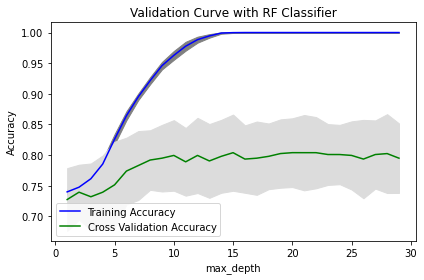

In [100]:

parameter_range = np.arange(1,30,1)
train_score, test_score = validation_curve(RandomForestClassifier(), X_res, y_res,
                                           param_name = "max_depth",
                                           param_range = parameter_range,
                                           cv = 10, scoring = "accuracy")

# mean and standard deviation (training)
mean_train = np.mean(train_score, axis = 1)
std_train = np.std(train_score, axis = 1)

# mean and standard deviation (testing)
mean_test = np.mean(test_score, axis = 1)
std_test = np.std(test_score, axis = 1)

# Plot mean accuracy (train and test)
plt.plot(parameter_range, mean_train,
         label = "Training Accuracy", color = 'b')
plt.plot(parameter_range, mean_test,
label = "Cross Validation Accuracy", color = 'g')
plt.fill_between(parameter_range, mean_train - std_train, mean_train + std_train, color="gray")
plt.fill_between(parameter_range, mean_test - std_test, mean_test + std_test, color="gainsboro")
# Creating the plot
plt.title("Validation Curve with RF Classifier")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

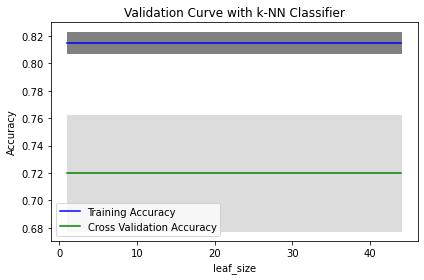

In [101]:
parameter_range = np.arange(1,45,1)
train_score, test_score = validation_curve(KNeighborsClassifier(), X_res, y_res,
                                           param_name = "leaf_size",
                                           param_range = parameter_range,
                                           cv = 10, scoring = "accuracy")

# mean and standard deviation (training)
mean_train = np.mean(train_score, axis = 1)
std_train = np.std(train_score, axis = 1)

# mean and standard deviation (testing)
mean_test = np.mean(test_score, axis = 1)
std_test = np.std(test_score, axis = 1)

# mean accuracy (training and testing)
plt.plot(parameter_range, mean_train,
         label = "Training Accuracy", color = 'b')
plt.plot(parameter_range, mean_test,
label = "Cross Validation Accuracy", color = 'g')
plt.fill_between(parameter_range, mean_train - std_train, mean_train + std_train, color="gray")
plt.fill_between(parameter_range, mean_test - std_test, mean_test + std_test, color="gainsboro")
# plot
plt.title("Validation Curve with k-NN Classifier")
plt.xlabel("leaf_size")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [102]:
Models_tuned = []
Models_tuned.append(('KNN',KNeighborsClassifier(**knn_best)))
Models_tuned.append(('RF',RandomForestClassifier(**rf_best)))

In [103]:
rf_best

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'n_estimators': 1000}

## Model evaluation 

### Random Forest

In [104]:
from sklearn.metrics import roc_curve
from sklearn import metrics

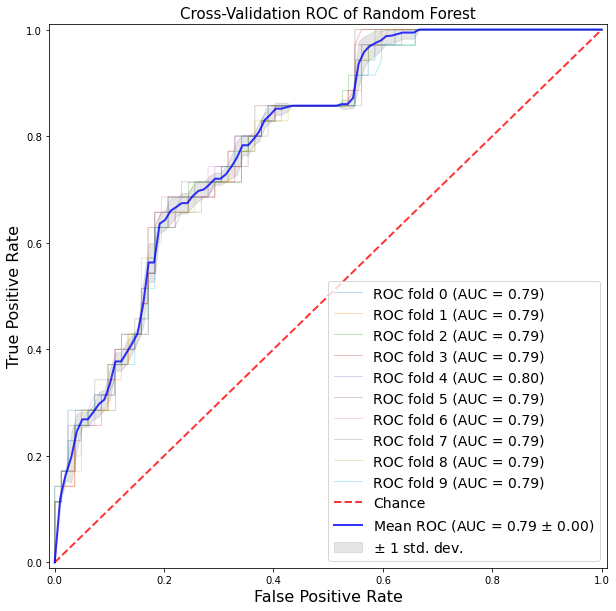

0.7926197035287944


In [105]:
classifier = RandomForestClassifier(**rf_best)
tpr_list = []
auc_list = []
cv = model_selection.KFold(n_splits=10,random_state = 111,shuffle=True)

mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X_res, y_res):
    probas_ = classifier.fit(X_res, y_res).predict_proba(X_holdout)
    # ROC and AUC
    fpr, tpr, thresholds = roc_curve(y_holdout, probas_[:, 1],pos_label=2)
    tpr_list.append(np.interp(mean_fpr, fpr, tpr))
    tpr_list[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    auc_list.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tpr_list, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tpr_list, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title('Cross-Validation ROC of Random Forest',fontsize=15)
plt.legend(loc="lower right", prop={'size': 14})
plt.show()
print(mean_auc)

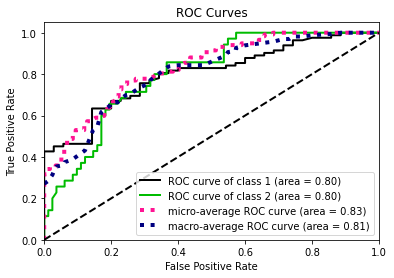

In [106]:
model = RandomForestClassifier(**rf_best)
model.fit(X_res, y_res)
y_probas = model.predict_proba(X_holdout)
skplt.metrics.plot_roc(y_holdout, y_probas)

plt.show()

In [107]:
model.score(X_holdout,y_holdout)

0.7521367521367521

In [108]:
y_pred = model.predict(X_holdout)

print(classification_report(y_holdout, y_pred))


              precision    recall  f1-score   support

           1       0.83      0.82      0.82        82
           2       0.58      0.60      0.59        35

    accuracy                           0.75       117
   macro avg       0.71      0.71      0.71       117
weighted avg       0.75      0.75      0.75       117



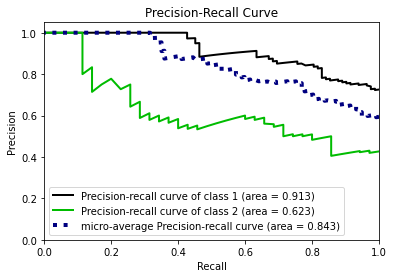

In [109]:
skplt.metrics.plot_precision_recall(y_holdout, y_probas)

plt.show()

In [110]:
tn, fp, fn, tp = confusion_matrix(list(y_holdout), list(y_pred), labels=[0, 1]).ravel()
accuracy_score(y_holdout, y_pred)

0.7521367521367521

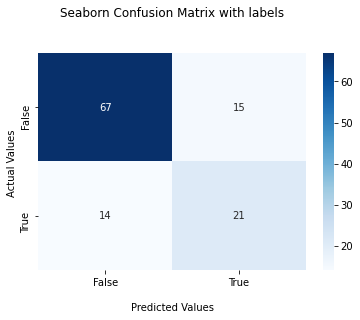

In [111]:
cf_matrix = confusion_matrix(y_holdout, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [112]:
model.fit(X_res,y_res)
scoring = ['precision_macro', 'recall_macro','accuracy']

scores = cross_validate(model, X_holdout, y_holdout, scoring=scoring)
sorted(scores.keys())
['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
scores['test_recall_macro']
print(scores)

{'fit_time': array([1.68436217, 3.35856938, 1.76151204, 1.96910691, 1.96183586]), 'score_time': array([0.24161005, 0.1288147 , 0.12553287, 0.1486299 , 0.11356497]), 'test_precision_macro': array([0.39495798, 0.625     , 0.70833333, 0.60714286, 0.63235294]), 'test_recall_macro': array([0.39495798, 0.58403361, 0.61160714, 0.54017857, 0.62053571]), 'test_accuracy': array([0.5       , 0.70833333, 0.73913043, 0.69565217, 0.69565217])}


In [113]:
#log loss
from sklearn.metrics import log_loss
log_loss(y_holdout,y_probas)

0.49029267426544076

In [114]:
#MAE
from sklearn.metrics import mean_absolute_error

mean_absolute_error(
    y_holdout,
    y_pred
)

0.24786324786324787

 ## K-nearest neighbors

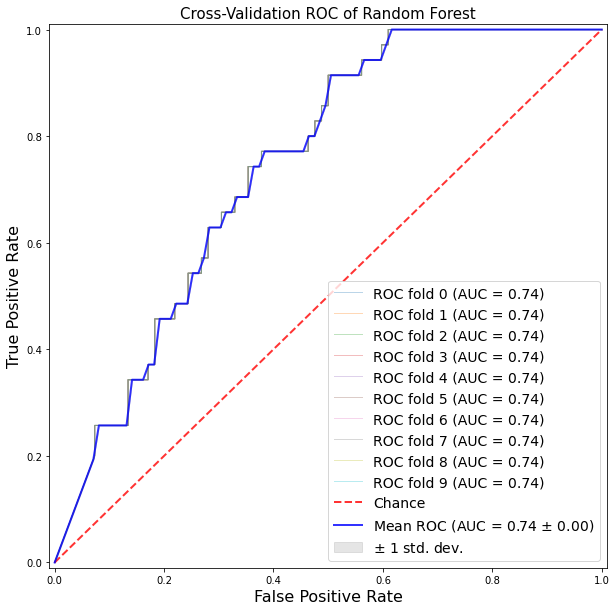

0.7424407616326808


In [115]:
classifier = KNeighborsClassifier(**knn_best)
tpr_list = []
auc_list = []
cv = model_selection.KFold(n_splits=10,random_state = 111,shuffle=True)

mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X_res, y_res):
    probas_ = classifier.fit(X_res, y_res).predict_proba(X_holdout)
    # ROC and AUC
    fpr, tpr, thresholds = roc_curve(y_holdout, probas_[:, 1],pos_label=2)
    tpr_list.append(np.interp(mean_fpr, fpr, tpr))
    tpr_list[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    auc_list.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tpr_list, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tpr_list, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title('Cross-Validation ROC of Random Forest',fontsize=15)
plt.legend(loc="lower right", prop={'size': 14})
plt.show()
print(mean_auc)

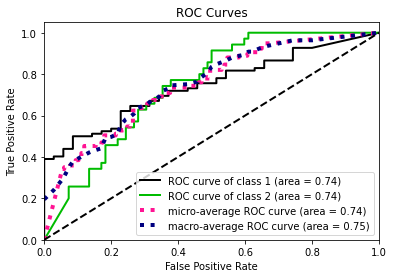

In [116]:
model2 = KNeighborsClassifier(**knn_best)
model2.fit(X_res, y_res)
y_probas = model2.predict_proba(X_holdout)
skplt.metrics.plot_roc(y_holdout, y_probas)

plt.show()

In [117]:
y_pred2 = model2.predict(X_holdout)
print(classification_report(y_holdout, y_pred2))

              precision    recall  f1-score   support

           1       0.85      0.65      0.74        82
           2       0.47      0.74      0.58        35

    accuracy                           0.68       117
   macro avg       0.66      0.69      0.66       117
weighted avg       0.74      0.68      0.69       117



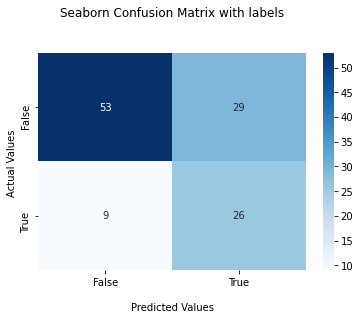

In [118]:
cf_matrix = confusion_matrix(y_holdout, y_pred2)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

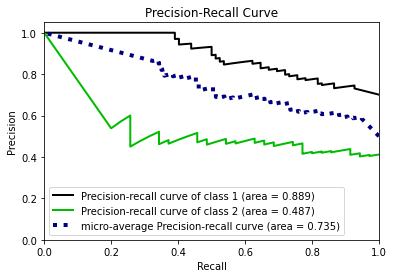

In [119]:
skplt.metrics.plot_precision_recall(y_holdout, y_probas)

plt.show()

In [120]:
#MAE
from sklearn.metrics import mean_absolute_error

mean_absolute_error(
    y_holdout,
    y_pred2
)

0.3247863247863248

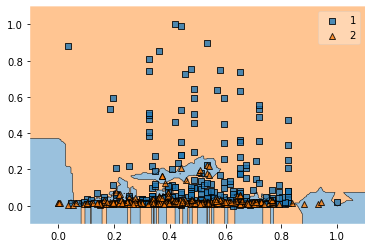

In [121]:
clf = KNeighborsClassifier(**knn_best)
clf.fit(X_res.iloc[:,:2],y_res)
plt.xlim(0, 0.8)
plt.ylim(0, 0.6)
plot_decision_regions(X_res.iloc[:,:2].values, y_res.values, clf=clf, zoom_factor=10)
plt.show()

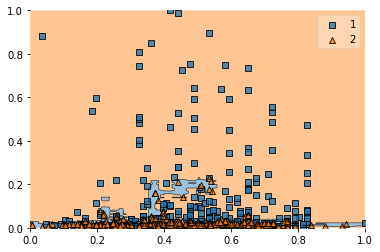

In [122]:
clf = RandomForestClassifier(**rf_best)
clf.fit(X_res.iloc[:,:2],y_res)
plt.xlim(0.4, 0.6)
plt.ylim(0, 0.3)
plot_decision_regions(X=X_res.iloc[:,:2].values, y=y_res.values, clf=clf, zoom_factor=100000)
plt.show()

#### Follow-up cross-validation 

In [123]:
print(Models_tuned)
for name, model in Models_tuned:

    scores = cross_val_score(model, X_holdout, y_holdout, cv=5)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[('KNN', KNeighborsClassifier(leaf_size=25, p=1, weights='distance')), ('RF', RandomForestClassifier(n_estimators=1000))]
0.65 accuracy with a standard deviation of 0.06
0.68 accuracy with a standard deviation of 0.10


In [124]:
#log loss
from sklearn.metrics import log_loss
log_loss(y_holdout,y_probas)

2.2367752063594404

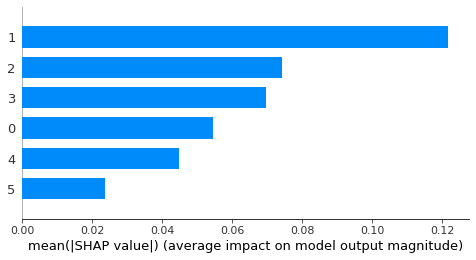

In [125]:

my_model_rf = RandomForestClassifier(**rf_best).fit(X_res, y_res)
explainer = shap.TreeExplainer(my_model_rf)
shap_values_rf = explainer.shap_values(X_holdout,y_holdout)
shap.summary_plot(shap_values_rf[1],X_res, plot_type="bar")

Using 668 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


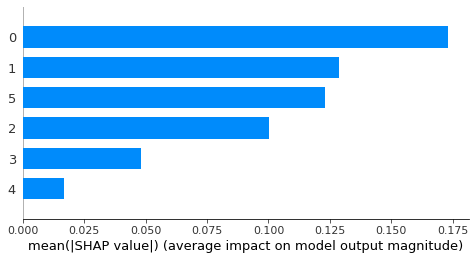

In [126]:
my_model_knn = KNeighborsClassifier(**knn_best).fit(X_res, y_res)
explainer = shap.KernelExplainer(my_model_knn.predict,X_res)
shap_values_knn = explainer.shap_values(X_holdout)
shap.summary_plot(shap_values_knn,X_res, plot_type="bar")

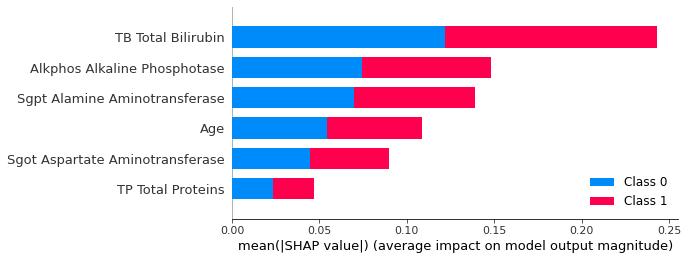

In [127]:
shap.summary_plot(shap_values_rf, X_holdout)

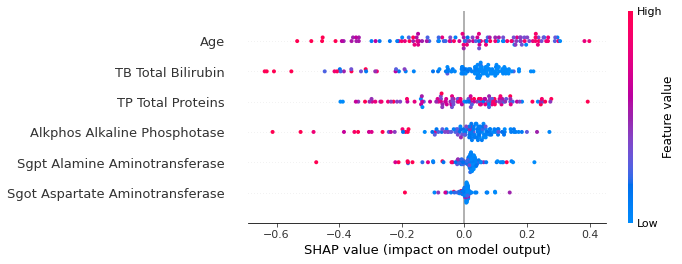

In [128]:
shap.summary_plot(shap_values_knn, X_holdout)

In [129]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_rf[1], X_holdout)

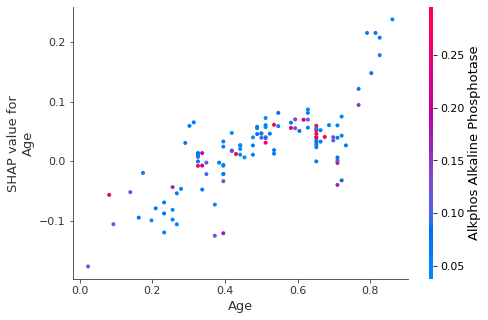

In [130]:
shap.dependence_plot("Age", shap_values_rf[0], X_holdout)

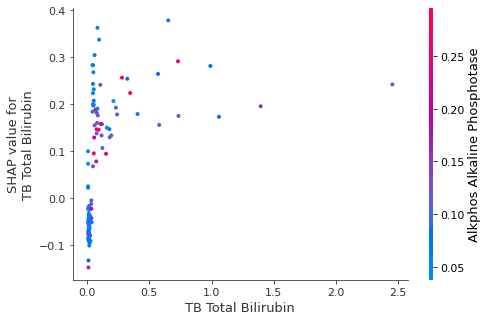

In [131]:
shap.dependence_plot("TB Total Bilirubin", shap_values_rf[0], X_holdout)

### Supplimentary data balance tests

In [ ]:
# type(y_holdout)

In [ ]:
# pd.set_option('display.max_rows', 100)
# y_holdout

In [ ]:
# type(X_holdout)

In [ ]:
# y_holdout.value_counts()

In [ ]:
# mask = (y_holdout < 2)
# idx, = np.where(mask)
# y_holdout_balanced = y_holdout.drop(y_holdout.index[idx[:len(idx)//2]])

In [ ]:
# y_holdout_balanced.value_counts()

In [ ]:
# X_holdout = pd.DataFrame(X_holdout)
# X_holdout_balanced = X_holdout[X_holdout.index.isin(y_holdout_balanced.index)]

#### Random Forest

In [ ]:
# model = RandomForestClassifier(**study.best_trial.params)
# model.fit(X_res, y_res)
# model.score(X_holdout,y_holdout)

In [ ]:
# model = RandomForestClassifier(**study.best_trial.params)
# model.fit(X_res, y_res)
# model.score(X_holdout_balanced,y_holdout_balanced)

In [ ]:
# y_pred = model.predict(X_holdout)

# print(classification_report(y_holdout, y_pred))

In [ ]:
### how does the model perform on balanced data?
# y_pred = model.predict(X_holdout_balanced)
# print(classification_report(y_holdout_balanced,y_pred))

#### KNN

In [ ]:
# model = KNeighborsClassifier(**study2.best_trial.params)
# model.fit(X_res, y_res)
# model.score(X_holdout,y_holdout)

In [ ]:
# model = KNeighborsClassifier(**study2.best_trial.params)
# model.fit(X_res, y_res)
# model.score(X_holdout_balanced,y_holdout_balanced)

In [ ]:
# y_pred = model.predict(X_holdout)
# print(classification_report(y_holdout,y_pred))

In [ ]:
# y_pred = model.predict(X_holdout_balanced)
# print(classification_report(y_holdout_balanced,y_pred))

Conclusion: A single model approach would yield a more efficient process and result

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Activation,Dropout
# from tensorflow.keras.models import Model

In [ ]:
# ip_layer = Input(shape=(X.shape[1],))
# dl1 = Dense(100, activation='relu')(ip_layer)
# dl2 = Dense(50, activation='relu')(dl1)
# dl3 = Dense(25, activation='relu')(dl2)
# dl4 = Dense(10, activation='relu')(dl3)
# output = Dense(1)(dl4)

In [ ]:
# model = Model(inputs = ip_layer, outputs=output)
# model.compile(loss="mean_absolute_error" , optimizer="adam", metrics=["mean_absolute_error"])

In [ ]:
# pip install graphviz

In [ ]:
# pip install pydot

In [ ]:
# import graphviz
# import pydot

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# history = model.fit(X_res, y_res, batch_size=5, epochs=500, verbose=1, validation_split=0.2)

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

In [ ]:
# y_pred = model.predict(X_holdout)

In [ ]:
# from sklearn import metrics
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_holdout, y_pred))
# print('Mean Squared Error:', metrics.mean_squared_error(y_holdout, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_holdout, y_pred)))